In [1]:
%matplotlib inline
# %matplotlib widget # 跟圖互動，可以用點選圖片中的某位置觸發程式
%env KERAS_BACKEND=tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import shuffle
# from matplotlib.widgets import Cursor, Button
from ipywidgets import interact, IntSlider, Button
from ipywidgets import interact_manual
import IPython.display as ipd
import networkx as nx # draw graph vertex & edge
import pydub # audio
from numpy.fft import fft, ifft, irfft, rfft # fourier transform
# import sympy as sym
# from sympy import S,N
# import locale # 資料處理 轉換數字格式

# from sklearn.linear_model import LinearRegression
# from keras.utils import np_utils #one hot encoding
# from keras.models import Sequential #神經網路的框架keras.models
from keras.layers import Dense, Activation, Embedding
# from keras.layers import LSTM
from keras.layers import Flatten # 將資料展平
# from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from keras.optimizers import SGD, Adadelta, Adam
from keras.models import model_from_json
# from keras.callbacks import History
# from keras.datasets import mnist # mnist內 包含手寫測試資料
# from keras.datasets import imdb # imdb內 包含電影評論資料
# from keras.preprocessing import sequence # 用來同整不同長度的電影評論，多的擷掉，少的補 0
# from keras.preprocessing.text import Tokenizer # 轉換文字成數字
# from sklearn.model_selection import train_test_split

# for Functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers import Reshape
# for Functional API transfer learning
from keras.layers.core import Lambda
from keras import backend as K
from keras import metrics

# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

# import matplotlib.image as mpimg # import image file

###################################################################
#################### setting functions for io #####################
###################################################################
def playAudio(x, rate = 0):
    if type(x)!=np.ndarray:
        ipd.display(ipd.Audio(x))
    elif rate == 0:
        print("input rate!")
        return
    elif len(x.shape) > 1:
        ipd.display(ipd.Audio(x.T.astype(int), rate = rate))
    else:
        ipd.display(ipd.Audio(x.astype(int), rate = rate))

def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

###################################################################
############### setting functions for training data ###############
###################################################################
def normalize(data):
    data = data - min_value
    data = data / (max_value - min_value)
    return data
def inverse_normalize(data):
    data = data * (max_value - min_value)
    data = data + min_value
    return data

# def fourier_transformation(aud_data):
#     global chennel_length_fourier, segement_length_fourier
#     chennel_length_fourier = 1 # = 2
#     for idx in range(len(aud_data)):
#         aud_data0 = np.zeros(2**(int(np.ceil(np.log2(len_data)))))
#         aud_data0[0:len_data] = aud_data[idx,:,0]
#         if chennel_length_fourier == 1:
#             fourier0 = fft(aud_data0).real.astype(float)
#             fourier0 = fourier0[0:len(fourier0)//2]
#         else:
#             fourier0 = fft(aud_data0).astype(float)
#         if idx == 0:
#             fourier = np.zeros((len(aud_data), len(fourier0), chennel_length_fourier))
#         fourier[idx,:,0] = fourier0
#         if chennel_length_fourier == 2:
#             fourier[idx,:,1] = fourier0.imag

#     global max_value_fourier, min_value_fourier
#     max_value_fourier = np.max(fourier.reshape(-1))
#     min_value_fourier = np.min(fourier.reshape(-1))
#     segement_length_fourier = len(fourier[0])
#     return fourier
# def inverse_fourier_transformation(fourier):
#     aud_data = np.zeros((len(fourier), len_data, 1))
#     for idx in range(len(fourier)):
#         if chennel_length_fourier == 1:
#             fourier0 = np.zeros(len(fourier[idx,:,0]) * 2)
#             fourier0[0:len(fourier[idx,:,0])] = fourier[idx,:,0]
#             fourier0[len(fourier[idx,:,0]):] = fourier[idx,:,0][::-1]
#             fourier0 = fourier0 + 1J * fourier0
#         else:
#             fourier0 = fourier[idx,:,0] + 1J * fourier[idx,:,1]
#         aud_data0 = ifft(fourier0).real
#         aud_data[idx,:,0] = aud_data0[0:len_data]
#     return aud_data

# def normalize_with_fourier(aud_data):
#     fourier = fourier_transformation(aud_data)
#     fourier = fourier - min_value_fourier
#     fourier = fourier / (max_value_fourier - min_value_fourier)
#     return fourier
# def inverse_normalize_with_fourier(fourier):
#     fourier = fourier * (max_value_fourier - min_value_fourier)
#     fourier = fourier + min_value_fourier
#     aud_data = inverse_fourier_transformation(fourier)
#     return aud_data

def setting_training_data():
    global train0, chennel_length_audio, segement_length_sec, segement_length_audio
    global chennel_length, segement_length
    chennel_length_audio = 1
    segement_length_sec = 2
    segement_length_audio = int(segement_length_sec * rate)
    train0 = song_array[0:segement_length_audio * (song_array.shape[0]//segement_length_audio), 0].copy()
    train0 = train0.reshape(-1, segement_length_audio).astype(float)

    global max_value, min_value
    max_value = np.max(train0.reshape(-1))
    min_value = np.min(train0.reshape(-1))
    train0 = normalize(train0)
    segement_length = segement_length_audio
    chennel_length = chennel_length_audio
# def setting_training_data_with_fourier():
#     global train0, len_data, chennel_length_audio, segement_length_sec, segement_length_audio
#     global chennel_length, segement_length
#     chennel_length_audio = 1
#     segement_length_sec = 2
#     segement_length_audio = int(segement_length_sec * rate)
#     train0 = song_array[0:segement_length_audio * (song_array.shape[0]//segement_length_audio), 0].copy()
#     train0 = train0.reshape(-1, segement_length_audio, chennel_length_audio).astype(float)

#     len_data = len(train0[0])
#     train0 = normalize_with_fourier(train0)
#     segement_length = segement_length_fourier
#     chennel_length = chennel_length_fourier

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [ ]:
###################### skip ######################
# import pydub
# from pydub.playback import play
# pydub.AudioSegment.converter = "C:\\FFmpeg\\ffmpeg-20190604-d81913e-win64-static\\bin\\ffmpeg.exe"

# song = pydub.AudioSegment.from_mp3("jazz.mp3")

# play(song)
# pydub.playback(song)
###################### skip ######################

# out_array = song_array[:int(len(song_array)/10)]/100
# write('out.mp3', rate, out_array, normalized=False)

# playAudio('out.mp3') # ipd.Audio('out.mp3')
# playAudio(out_array, rate = rate) # ipd.Audio(out_array.T, rate = rate) # ipd.Audio(out_array[:,1], rate = rate)

# sr = 22050 # sample rate
# T = 2.0    # seconds
# t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
# x = 0.5 * np.sin(2*np.pi*440*t)
# playAudio(x, rate=sr) # ipd.Audio(x, rate = sr)

#### setting training data

In [2]:
rate, song_array = read('jazz.mp3', normalized=False)
setting_training_data()
# setting_training_data_with_fourier()

print("frame_rate = ", rate, "(每秒鐘會產生", rate, "長度的陣列)")
# print("song_array = \n", song_array)
# print("song_array.shape = ", song_array.shape)
print("There are", train0.shape[0], "segements in train0.")
print("train0[87] = \n", train0[87])

frame_rate =  48000 (每秒鐘會產生 48000 長度的陣列)
There are 900 segements in train0.
train0[87] = 
 [0.49777981 0.48760204 0.42873274 ... 0.40015259 0.41074235 0.41205463]


#### modeling

In [3]:
input_dim = 10
fourier_output_lenth = segement_length//2 + 1 if segement_length % 2 == 0 else (segement_length + 1)//2

################################ generator ################################
generator_audio_input = Input(shape = (input_dim,), name = 'generator_audio_input')
z = Dense(input_dim, activation = 'selu', name = 'generator_audio_d1')(generator_audio_input)
z = Dense(input_dim, activation = 'selu', name = 'generator_audio_d2')(z)
z = Dense(input_dim, activation = 'selu', name = 'generator_audio_d3')(z)
z = Dense(input_dim, activation = 'selu', name = 'generator_audio_d4')(z)
z = Dense(segement_length //1000, activation = 'selu', name = 'generator_audio_d5')(z)
z = Dense(segement_length //100, activation = 'selu', name = 'generator_audio_d6')(z)
z = Dense(segement_length, activation = 'sigmoid', name = 'generator_audio_d7')(z)
intermediate_audio_output = Reshape((-1, ), name = 'generator_audio')(z)

generator_fourier_input = Input(shape = (input_dim,), name = 'generator_fourier_input')

z = Dense(input_dim, activation = 'selu', name = 'generator_fourier_real_d1')(generator_fourier_input)
z = Dense(input_dim, activation = 'selu', name = 'generator_fourier_real_d2')(z)
z = Dense(fourier_output_lenth //1000, activation = 'selu', name = 'generator_fourier_real_d3')(z)
z = Dense(fourier_output_lenth //100, activation = 'selu', name = 'generator_fourier_real_d4')(z)
z = Dense(fourier_output_lenth //10, activation = 'selu', name = 'generator_fourier_real_d5')(z)
generator_fourier_real = Dense(fourier_output_lenth, activation = 'selu', name = 'generator_fourier_real_d6')(z)

z = Dense(input_dim, activation = 'selu', name = 'generator_fourier_imag_d1')(generator_fourier_input)
z = Dense(input_dim, activation = 'selu', name = 'generator_fourier_imag_d2')(z)
z = Dense(fourier_output_lenth //1000, activation = 'selu', name = 'generator_fourier_imag_d3')(z)
z = Dense(fourier_output_lenth //100, activation = 'selu', name = 'generator_fourier_imag_d4')(z)
z = Dense(fourier_output_lenth //10, activation = 'selu', name = 'generator_fourier_imag_d5')(z)
generator_fourier_imag = Dense(fourier_output_lenth, activation = 'selu', name = 'generator_fourier_imag_d6')(z)

z = Lambda(lambda v: K.sigmoid(tf.signal.irfft(tf.complex(v[0], v[1]))), 
           name = 'generator_irfft0')([generator_fourier_real, generator_fourier_imag])
generator_irfft_output = Reshape((-1, ), name = 'generator_irfft')(z)

generator_output = Lambda(lambda v: (v[0] + v[1]) / 2., name = 'generator_L1')([intermediate_audio_output, generator_irfft_output])
generator = Model([generator_audio_input, generator_fourier_input], generator_output, name = 'generator')
print(generator.summary())

################################ discriminator ################################
data_input = Input(shape = (segement_length, ), name = 'discriminator_data_input')
z = Reshape((-1, 1), name = 'discriminator_data_input_reshape')(data_input)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_audio_c1')(z)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_audio_c2')(z)
z = Conv1D(16, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_audio_c3')(z)
z = MaxPool1D(pool_size = rate//100, padding = 'same', name = 'discriminator_audio_p1')(z)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_audio_c4')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name = 'discriminator_audio_p2')(z)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_audio_c5')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name = 'discriminator_audio_p3')(z)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name = 'discriminator_audio_c6')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name = 'discriminator_audio_p4')(z)
z = Flatten(name = 'discriminator_audio_f1')(z)
z = Dense(10, activation = 'selu', name = 'discriminator_audio_d1')(z)
z = Dense(10, activation = 'selu', name = 'discriminator_audio_d2')(z)
discriminator_audio_output = Dense(10, activation = 'selu', name = 'discriminator_audio_d3')(z)

z = Lambda(lambda v: tf.signal.rfft(v), name = 'discriminator_rfft')(data_input)
rfft_output = Reshape((-1, ), name = 'discriminator_rfft_re')(z)
rfft_real = Lambda(lambda v: tf.real(v), name = 'discriminator_rfft_real')(rfft_output)
rfft_imag = Lambda(lambda v: tf.imag(v), name = 'discriminator_rfft_imag')(rfft_output)
rfft_real_reshape = Reshape((-1, 1), name = 'discriminator_rfft_real_reshape')(rfft_real)
rfft_imag_reshape = Reshape((-1, 1), name = 'discriminator_rfft_imag_reshape')(rfft_imag)

z = Conv1D(4, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_real_c1')(rfft_real_reshape)
z = Conv1D(8, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_real_c2')(z)
z = Conv1D(16, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_real_c3')(z)
z = MaxPool1D(pool_size = fourier_output_lenth//100, padding = 'same', name = 'discriminator_fourier_real_p1')(z)
z = Conv1D(4, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_real_c4')(z)
z = MaxPool1D(pool_size = fourier_output_lenth//10000, padding = 'same', name = 'discriminator_fourier_real_p2')(z)
z = Conv1D(8, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_real_c5')(z)
z = MaxPool1D(pool_size = fourier_output_lenth//10000, padding = 'same', name = 'discriminator_fourier_real_p3')(z)
z = Conv1D(4, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_real_c6')(z)
z = MaxPool1D(pool_size = fourier_output_lenth//10000, padding = 'same', name = 'discriminator_fourier_real_p4')(z)
fourier_real = Flatten(name = 'discriminator_fourier_real_f1')(z)

z = Conv1D(4, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_imag_c1')(rfft_imag_reshape)
z = Conv1D(8, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_imag_c2')(z)
z = Conv1D(16, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_imag_c3')(z)
z = MaxPool1D(pool_size = fourier_output_lenth//100, padding = 'same', name = 'discriminator_fourier_imag_p1')(z)
z = Conv1D(4, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_imag_c4')(z)
z = MaxPool1D(pool_size = fourier_output_lenth//10000, padding = 'same', name = 'discriminator_fourier_imag_p2')(z)
z = Conv1D(8, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_imag_c5')(z)
z = MaxPool1D(pool_size = fourier_output_lenth//10000, padding = 'same', name = 'discriminator_fourier_imag_p3')(z)
z = Conv1D(4, fourier_output_lenth//1000, padding = 'same', activation = 'selu', name = 'discriminator_fourier_imag_c6')(z)
z = MaxPool1D(pool_size = fourier_output_lenth//10000, padding = 'same', name = 'discriminator_fourier_imag_p4')(z)
fourier_imag = Flatten(name = 'discriminator_fourier_imag_f1')(z)
z = concatenate([fourier_real, fourier_imag], name = 'discriminator_fourier_concatenate')
z = Dense(10, activation = 'selu', name = 'discriminator_fourier_d1')(z)
z = Dense(10, activation = 'selu', name = 'discriminator_fourier_d2')(z)
discriminator_fourier_output = Dense(10, activation = 'selu', name = 'discriminator_fourier_d3')(z)

z = concatenate([discriminator_audio_output, discriminator_fourier_output], name = 'discriminator_concatenate')
z = Dense(10, activation = 'selu', name = 'discriminator_d1')(z)
z = Dense(10, activation = 'selu', name = 'discriminator_d2')(z)
z = Dense(10, activation = 'selu', name = 'discriminator_d3')(z)
solution = Dense(1, activation = 'sigmoid', name = 'discriminator_solution')(z)

discriminator = Model(data_input, solution, name = 'discriminator')
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
print(discriminator.summary())

################################ combined ################################
combined_audio_input = Input(shape=(input_dim,), name = 'combined_audio_input')
combined_fourier_input = Input(shape=(input_dim,), name = 'combined_fourier_input')
z = generator([combined_audio_input, combined_fourier_input])
discriminator.trainable = False
combined_output = discriminator(z)
combined = Model([combined_audio_input, combined_fourier_input], combined_output, name = 'combined')
combined.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.0001, decay = 0.000001), metrics = ['accuracy'])
print(combined.summary())

################################ VAE ################################
VAE_input = Input(shape=(segement_length, ), name = 'VAE_input')
z = Reshape((-1, 1), name = 'VAE_input_reshape')(VAE_input)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name = 'encoder_c1')(z)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name = 'encoder_c2')(z)
z = Conv1D(16, rate//1000, padding = 'same', activation = 'selu', name = 'encoder_c3')(z)
z = MaxPool1D(pool_size = rate//500, padding = 'same', name = 'encoder_p1')(z)
z = Flatten(name = 'encoder_f1')(z)
z = Dense(input_dim, activation = 'selu', name = 'encoder_d1')(z)
z = Dense(input_dim, activation = 'selu', name = 'encoder_d2')(z)
encoder_audio_mean = Dense(input_dim, activation = 'selu', name = 'encoder_audio_mean')(z)
encoder_audio_log_var = Dense(input_dim, activation = 'selu', name = 'encoder_audio_log_var')(z)
encoder_fourier_mean = Dense(input_dim, activation = 'selu', name = 'encoder_fourier_mean')(z)
encoder_fourier_log_var = Dense(input_dim, activation = 'selu', name = 'encoder_fourier_log_var')(z)
def VAE_sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (input_dim,), mean = 0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon
encoder_audio_output = Lambda(VAE_sampling, output_shape=(input_dim,), name = 'encoder_audio_output')([encoder_audio_mean, encoder_audio_log_var])
encoder_fourier_output = Lambda(VAE_sampling, output_shape=(input_dim,), name = 'encoder_fourier_output')([encoder_fourier_mean, encoder_fourier_log_var])
VAE_output = generator([encoder_audio_output, encoder_fourier_output])
VAE = Model(VAE_input, VAE_output, name = 'VAE')
def VAE_loss(x, x_recon):
    # recovery_loss = segement_length * metrics.mean_squared_error(x, x_recon)
    recovery_loss = 100 * metrics.mean_squared_error(x, x_recon)
    KL_loss_audio = - 0.5 * K.sum(1 + encoder_audio_log_var - K.square(encoder_audio_mean) - K.exp(encoder_audio_log_var), axis=-1)
    KL_loss_fourier = - 0.5 * K.sum(1 + encoder_fourier_log_var - K.square(encoder_fourier_mean) - K.exp(encoder_fourier_log_var), axis=-1)
    return recovery_loss + KL_loss_audio + KL_loss_fourier
VAE.compile(loss = VAE_loss, optimizer = Adam(), metrics = ['accuracy'])
print(VAE.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_audio_input (InputLay (None, 10)           0                                            
__________________________________________________________________________________________________
generator_fourier_input (InputL (None, 10)           0                                            
__________________________________________________________________________________________________
generator_audio_d1 (Dense)      (None, 10)           110         generator_audio_input[0][0]      
__________________________________________________________________________________________________
generator_fourier_real_d1 (Dens (None, 10)           110         generator_fourier_input[0][0]    
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
combined_audio_input (InputLaye (None, 10)           0                                            
__________________________________________________________________________________________________
combined_fourier_input (InputLa (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 96000)        557922354   combined_audio_input[0][0]       
                                                                 combined_fourier_input[0][0]     
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            43401       generator[1][0]                  
Total para

In [4]:
# # input_dim = 10

# # generator = model_from_json(open('json_h5/GAN_generator.json').read())
# # discriminator = model_from_json(open('json_h5/GAN_discriminator.json').read())
# # combined = model_from_json(open('json_h5/GAN_combined.json').read())

# generator.load_weights('json_h5/GAN_generator.h5')
# discriminator.load_weights('json_h5/GAN_discriminator.h5')

# # generator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# combined.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [5]:
def sampling(mean = 0., std = 1., batch = 1, input_dim = 10):
    return (np.random.normal(size = input_dim * batch) * std + mean).reshape(batch, input_dim)

def GAN(epochs = 1, batch = 16, times = 3):
    for i in range(epochs):
        print("\n****************************************\n   Epoch = ", i+1, "/", epochs)

        for j in range(20):
            if j == 0 and 'discriminator_history' in vars():
                discriminator_history.history['acc'] = []
            print("prepare data for discriminator...")
            x_train = np.zeros((batch * 2, segement_length))
            shu = np.arange(len(train0))
            shuffle(shu)
            for idx in range(batch):
                x_train[idx] = train0[shu[idx]].copy()
            samples_audio = sampling(mean = 0, std = 10, batch = batch, input_dim = input_dim)
            samples_fourier = sampling(mean = 0, std = 10, batch = batch, input_dim = input_dim)
            x_train[batch:] = generator.predict([samples_audio, samples_fourier])
            y_train = np.array([1] * batch + [0] * batch)
            print("discriminator training...")
            discriminator_history = discriminator.fit(x_train, y_train, batch_size = batch * 2, shuffle = True, epochs = 1);
            if discriminator_history.history['acc'][-1] > 0.96:
                break
        if j == 20 - 1:
            break

        print("prepare data for generator...")
        # times = 3
        x_train_audio_combined = sampling(mean = 0, std = 1, batch = batch * times, input_dim = input_dim)
        x_train_fourier_combined = sampling(mean = 0, std = 1, batch = batch * times, input_dim = input_dim)
        y_train_combined = np.array([1] * batch * times)
        print("generator training...")
        combined.fit([x_train_audio_combined, x_train_fourier_combined], y_train_combined, batch_size = batch, epochs = 1);

In [6]:
start = 300
end = start + 10
lr = 0.001
decay = 0.01
# VAE.compile(loss = VAE_loss, optimizer = Adam(lr = lr, decay = decay))
VAE.compile(loss = VAE_loss, optimizer = Adam(lr = lr, decay = decay), metrics = ['accuracy'])
# VAE.compile(loss = VAE_loss, optimizer = Adam(lr = lr), metrics = ['accuracy'])
# VAE.compile(loss = VAE_loss, optimizer = Adam(), metrics=['accuracy'])

VAE.fit(train0[start:end], train0[start:end], batch_size = 1, epochs = 1);

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
10/10 [==============================] - 472s 47s/step - loss: 33.7373 - acc: 0.0000e+00


In [ ]:
GAN(epochs = 1, batch = 32, times = 2)
# GAN(epochs = 1, batch = 2, times = 1)


****************************************
   Epoch =  1 / 1
prepare data for discriminator...
discriminator training...
Epoch 1/1
64/64 [==============================] - 51s 798ms/step - loss: 1.0281 - acc: 0.5000
prepare data for discriminator...
discriminator training...
Epoch 1/1
64/64 [==============================] - 35s 552ms/step - loss: 1.0308 - acc: 0.5000
prepare data for discriminator...
discriminator training...
Epoch 1/1
64/64 [==============================] - 36s 560ms/step - loss: 1.0297 - acc: 0.5000
prepare data for discriminator...
discriminator training...
Epoch 1/1
64/64 [==============================] - 39s 617ms/step - loss: 1.0284 - acc: 0.5000
prepare data for discriminator...
discriminator training...
Epoch 1/1
64/64 [==============================] - 46s 711ms/step - loss: 1.0351 - acc: 0.5000
prepare data for discriminator...
discriminator training...
Epoch 1/1
64/64 [==============================] - 35s 552ms/step - loss: 1.0258 - acc: 0.5000
prepare da

In [6]:
open('json_h5/GAN_generator.json','w').write(generator.to_json())
open('json_h5/GAN_discriminator.json','w').write(discriminator.to_json())
open('json_h5/GAN_combined.json','w').write(combined.to_json())

generator.save_weights('json_h5/GAN_generator.h5')
discriminator.save_weights('json_h5/GAN_discriminator.h5')

#### Let's generate some jazz

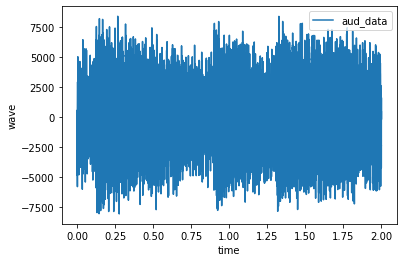

In [15]:
samples_audio = sampling(mean = 0, std = 10, batch = 1, input_dim = input_dim)
samples_fourier = sampling(mean = 0, std = 10, batch = 1, input_dim = input_dim)
predicts = generator.predict([samples_audio, samples_fourier])
play_predicts = inverse_normalize(predicts[0])
playAudio(play_predicts, rate = rate)

plt.figure(1)
t = np.linspace(0, segement_length_sec, segement_length)
plt.plot(t, play_predicts, label='aud_data')
plt.xlabel('time')
plt.ylabel('wave')
plt.legend()
plt.show()

In [18]:
idx = 250
playAudio(song_array[segement_length_audio * idx:segement_length_audio * (idx+1), 0], rate = rate)
# playAudio(inverse_normalize_with_fourier(train0[idx].reshape(1,-1, chennel_length_fourier)).reshape(-1, 1), rate = rate)

#### Show data

131072 86296465.61766818 108799240.5486259


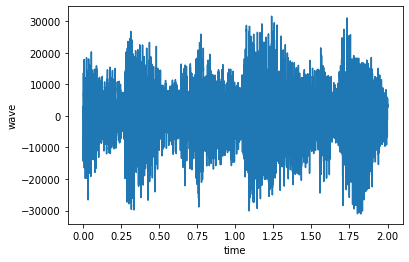

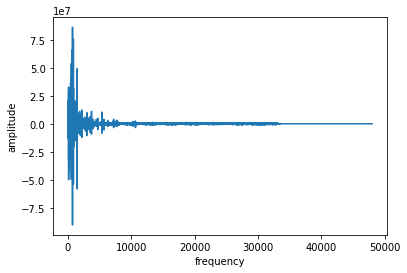

c:\users\奎佑\appdata\local\programs\python\python36\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


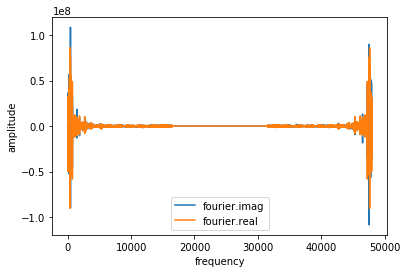

In [3]:
aud_data = song_array[segement_length_audio*23:segement_length_audio*24, 0].copy()

len_data = len(aud_data)
channel_1 = np.zeros(2**(int(np.ceil(np.log2(len_data)))))
channel_1[0:len_data] = aud_data
fourier = fft(channel_1)
t = np.linspace(0, segement_length_sec, len_data)
w = np.linspace(0, rate, len(fourier)//2)
fourier_to_plot = fourier[0:len(fourier)//2].real

plt.figure(1)
plt.plot(t, aud_data, label='aud_data')
plt.xlabel('time')
plt.ylabel('wave')
plt.figure(2)
plt.plot(w, fourier_to_plot, label='fourier_to_plot')
plt.xlabel('frequency')
plt.ylabel('amplitude')
# plt.show()

# plt.plot(w, fourier_to_plot, label='fourier_to_plot')
print(len(fourier), np.max(fourier.real), np.max(fourier.imag))
plt.figure(3)
w1 = np.linspace(0, rate, len(fourier))
plt.plot(w1, fourier.imag, label='fourier.imag')
plt.plot(w1, fourier.real, label='fourier.real')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.legend()
plt.show()